# Analysis

This script contains the code required to analyse and compare several CNN models against MetOffice Rainfall.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from alibi.explainers import IntegratedGradients
from tqdm.notebook import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import plotting

In [2]:
regions = ["ES","NS", "WS","EM","EE","LD","NEE","NWE","SEE","SWE","WAL","WM","YH"]
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

## Data Acquisition (Validation Only)

First, data and models need extracting. The MetOffice and benchmark (CEH-GEAR) data is first to be extracted.

In [22]:
all_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/expected_all.npy"
benchmark_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/expected_all.npy"
mo_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/mo_all.npy"

all_rf = np.load(all_rf)[:, 2:]
benchmark_rf = np.load(benchmark_rf)
mo_rf = np.load(mo_rf)[:, 2:]

In [23]:
def get_video_data(file):
    videos = np.load(file)
    videos = np.swapaxes(videos, 1, 2)
    videos = np.swapaxes(videos, 2, 3)
    videos = np.swapaxes(videos, 3, 4)
    stats = np.load("D:/PHD_DATA/Video_11-02-2021/prepared-data/middle_all.npy")
    videos[:, :, :, :, 0] = (videos[:, :, :, :, 0] - np.mean(stats[:, :, :, :, 0])) / (np.std(stats[:, :, :, :, 0]))
    videos[:, :, :, :, 1] = (videos[:, :, :, :, 1] - np.mean(stats[:, :, :, :, 1])) / (np.std(stats[:, :, :, :, 1]))
    return videos

def get_frame_data(file):
    frame = np.load(file)
    frame = np.swapaxes(frame, 1, 2)
    frame = np.swapaxes(frame, 2, 3)
    stats = np.load("D:/PHD_DATA/Video_11-02-2021/prepared-data/middle_all.npy")
    frame[:, :, :, 0] = (frame[:, :, :, 0] - np.mean(stats[:, :, :, :, 0])) / (np.std(stats[:, :, :, :, 0]))
    frame[:, :, :, 1] = (frame[:, :, :, 1] - np.mean(stats[:, :, :, :, 1])) / (np.std(stats[:, :, :, :, 1]))
    return frame

In [24]:
videos = get_video_data("D:/PHD_DATA/Video_11-02-2021/prepared-data/middle_all.npy")
frames = get_frame_data("D:/PHD_DATA/Video_11-02-2021/prepared-data/single_all.npy")

Next, the best performing models are selected and loaded.

In [6]:
single_frame_models = ["ES-1613144925","NS-1613145487","WS-1613145925","EM-1613146122","EE-1613146475","LD-1613146544",
                       "NEE-1613146804","NWE-1613147122","SEE-1613147399","SWE-1613147550","WAL-1613147584",
                       "WM-1613147875","YH-1613148002"]
slow_fusion_models = ["ES-1613065474","NS-1613068975","WS-1613071908","EM-1613074818","EE-1613079692","LD-1613082862",
                      "NEE-1613085567","NWE-1613087292","SEE-1613088892","SWE-1613121864","WAL-1613094356",
                      "WM-1613096188","YH-1613101007"]
earl_fusion_models = ["ES-1613391631","NS-1613405705","WS-1613469119","EM-1613488724","EE-1613518618","LD-1613548378",
                      "NEE-1613569618","NWE-1613588114","SEE-1613620883","SWE-1613646498","WAL-1613689774",
                      "WM-1613699686","YH-1613730530"]

In [7]:
def load_models(names, folder):
    models = []
    for n in tqdm(names):
        models.append(load_model(folder + n + ".mdl"))
    return models

In [8]:
single_frame_models = load_models(single_frame_models, folder="D:/PHD_DATA/Video_11-02-2021/SingleFrame/models/")
slow_fusion_models = load_models(slow_fusion_models, folder="D:/PHD_DATA/Video_11-02-2021/SlowFusion/models/")
early_fusion_models = load_models(earl_fusion_models, folder="D:/PHD_DATA/Video_11-02-2021/EarlyFusion/models/")

## Evaluation

Next, each model is evaluated by taking the RMSE for each region and comparing this to the MetOffice's RMSE.

In [25]:
reevaluate = True

In [26]:
def get_predictions(models, inputs, regions):
    """ Generates a matrix of predictions for the given model set.
        Params:
            models - A set of tensorflow models in the same order as regions.
    """
    predictions = []
    for ridx, r in tqdm(enumerate(regions), total=len(regions)):
        model_preds = []
        for iidx, v in enumerate(inputs):
            model_preds.append(
                models[ridx](np.expand_dims(v, 0))
            )
        predictions.append(model_preds)
    return np.array(predictions)

In [27]:
if reevaluate:
    single_frame_predictions = get_predictions(single_frame_models, frames, regions).squeeze()
    slow_fusion_predictions = get_predictions(slow_fusion_models, videos, regions).squeeze()
    early_fusion_predictions = get_predictions(early_fusion_models, videos, regions).squeeze()
else:
    single_frame_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/single-frame.npy")
    slow_fusion_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/slow-fusion.npy")
    early_fusion_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/early-fusion.npy")

# Unnormalize
for ridx, r in enumerate(regions):
    single_frame_predictions[ridx, :] = (single_frame_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])
    slow_fusion_predictions[ridx, :] = (slow_fusion_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])
    early_fusion_predictions[ridx, :] = (early_fusion_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])

Now we have the predictions it's time to plot the RMSEs for each region.

In [28]:
def get_regional_rmses(model_predictions, mo_preds, benchmark, regions):
    ## RMSES
    # 0: Single Frame
    # 1: Slow Fusion
    # 2: Early Fusion
    # 3: Met Office
    ##
    rmses = np.zeros((len(regions), len(model_predictions) + 1))
    for ridx, r in enumerate(regions):
        for midx, m in enumerate(model_predictions):
            rmses[ridx, midx] = np.sqrt(np.mean(np.power((benchmark[:, ridx] - m[ridx, :]), 2)))
        rmses[ridx, -1] = np.sqrt(np.mean(np.power((benchmark[:, ridx] - mo_rf[:, ridx]), 2)))
    return rmses

rmses = get_regional_rmses([single_frame_predictions, slow_fusion_predictions, early_fusion_predictions], mo_rf, benchmark_rf[:, 2:], regions)

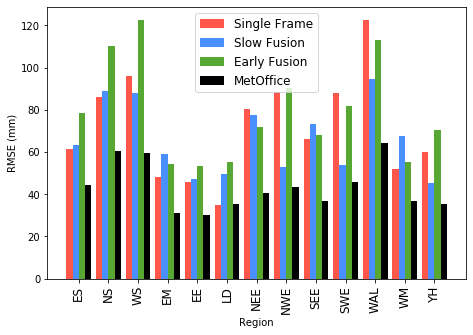

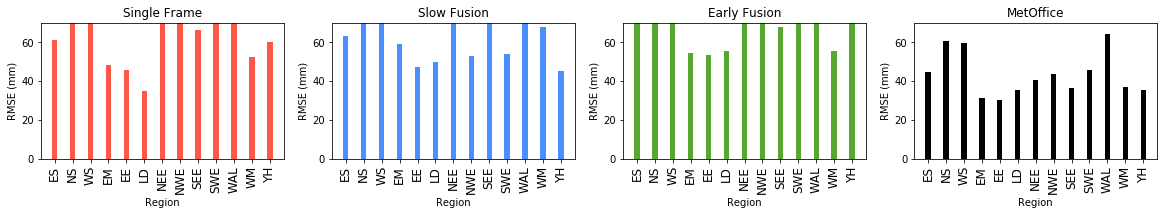

In [29]:
def plot_rmses_one(rmses, labels, regions):
    plt.rcParams['figure.figsize'] = [7.5, 5]
    fig, axs = plt.subplots(nrows=1, ncols=1)
    width = 0.25
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    bars = [None, None, None, None]
    positions = [-width*1.5, -width/2, width/2, width*1.5]
    xs = []
    
    for ridx, r in enumerate(regions):
        for rmseidx, rmse in enumerate(rmses[ridx, :]):
            bars[rmseidx] = axs.bar(
                ridx+positions[rmseidx]+0.2*ridx,
                rmse,
                color=colours[rmseidx],
                width=width,
                label=labels[rmseidx]
            )
        xs.append(ridx+0.2*ridx)
    axs.set_ylabel("RMSE (mm)")
    axs.set_xlabel("Region")
    
    axs.set_xticks(xs)
    axs.set_xticklabels(regions, rotation=90, fontsize=12)
    
    axs.legend(bars, labels, fontsize=12)

def plot_rmses_several(rmses, labels, regions):
    plt.rcParams['figure.figsize'] = [5*rmses.shape[1], 2.5]
    fig, axs = plt.subplots(nrows=1, ncols=rmses.shape[1])
    width = 0.3
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    for rmseidx in range(0, rmses.shape[1]):
        for ridx, r in enumerate(regions):
            axs[rmseidx].bar(
                ridx,
                rmses[ridx, rmseidx],
                color=colours[rmseidx],
                width=width,
                label=labels[rmseidx]
            )
        
        axs[rmseidx].set_ylabel("RMSE (mm)")
        axs[rmseidx].set_xlabel("Region")

        axs[rmseidx].set_xticks(range(0, 13))
        axs[rmseidx].set_xticklabels(regions, rotation=90, fontsize=12)
        axs[rmseidx].set_title(labels[rmseidx])    
        
        axs[rmseidx].set_ylim([0, 70])
plot_rmses_one(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], regions)
plot_rmses_several(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], regions)

### Month based errors

In [82]:
def get_monthly_rmses(model_predictions, mo_preds, benchmark, months):
    month_rmses = np.zeros((12, len(model_predictions) + 1))
    for midx, month in enumerate(range(1, 13)):
        for model_idx, model_preds in enumerate(model_predictions):
            month_rmses[midx, model_idx] = np.sqrt(np.mean(np.power((benchmark_rf[months == month, 2:] - model_preds[:, months == month].T), 2)))
        month_rmses[midx, -1] = np.sqrt(np.mean(np.power((benchmark_rf[months == month, 2:] - mo_rf[months == month, :]), 2)))
    return month_rmses


rmses = get_monthly_rmses(
    [single_frame_predictions, slow_fusion_predictions, early_fusion_predictions],
    mo_rf,
    benchmark_rf[:, 2:],
    benchmark_rf[:, 0])

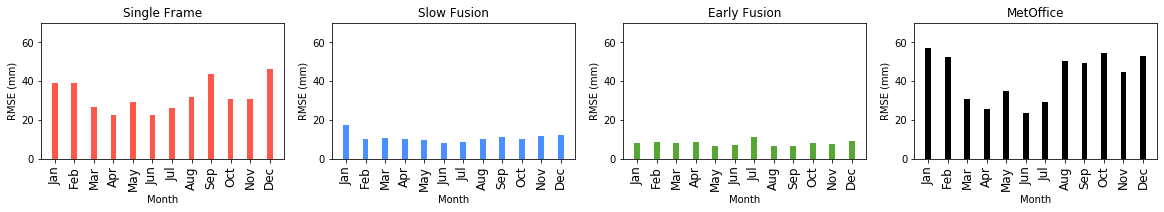

In [83]:
def plot_rmses_one(rmses, labels, months):
    plt.rcParams['figure.figsize'] = [7.5, 5]
    fig, axs = plt.subplots(nrows=1, ncols=1)
    width = 0.25
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    bars = [None, None, None, None]
    positions = [-width*1.5, -width/2, width/2, width*1.5]
    xs = []
    
    for midx in range(0, 12):
        for rmseidx, rmse in enumerate(rmses[midx, :]):
            bars[rmseidx] = axs.bar(
                midx+positions[rmseidx]+0.2*midx,
                rmse,
                color=colours[rmseidx],
                width=width,
                label=months[midx]
            )
        xs.append(midx+0.2*midx)
    axs.set_ylabel("RMSE (mm)")
    axs.set_xlabel("Region")
    
    axs.set_xticks(xs)
    axs.set_xticklabels(months, rotation=90, fontsize=12)
    
    axs.legend(bars, labels, fontsize=12)
    
def plot_rmses_several(rmses, labels, regions):
    plt.rcParams['figure.figsize'] = [5*rmses.shape[1], 2.5]
    fig, axs = plt.subplots(nrows=1, ncols=rmses.shape[1])
    width = 0.3
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    for midx in range(0, 12):
        for rmseidx, rmse in enumerate(rmses[midx, :]):
            axs[rmseidx].bar(
                midx,
                rmses[midx, rmseidx],
                color=colours[rmseidx],
                width=width,
                label=labels[rmseidx]
            )
        
            axs[rmseidx].set_ylabel("RMSE (mm)")
            axs[rmseidx].set_xlabel("Month")

            axs[rmseidx].set_xticks(range(0, 12))
            axs[rmseidx].set_xticklabels(months, rotation=90, fontsize=12)
            axs[rmseidx].set_title(labels[rmseidx])    

            axs[rmseidx].set_ylim([0, 70])

#plot_rmses_one(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], months)
plot_rmses_several(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], regions)

## Sensitivity Analysis

In [174]:
def video_generator(count):
    videos = np.random.normal(0, 1, (count, 28, 61, 121, 2))
    return videos

def monte_carlo_simulation_video(model, count, sim_name="test1", folder="D:/PHD_DATA/Video_11-02-2021/monte-carlo/"):
    outputs = np.zeros(count)
    random_data = video_generator(count)
    
    for idx in tqdm(range(0, count)):
        outputs[idx] = model(np.expand_dims(random_data[idx, :, :, :, :], 0))
    
    np.save(folder + sim_name + "-outputs.npy", outputs)
    np.save(folder + sim_name + "-inputs.npy", random_data)
    return random_data, outputs

def get_video_correlations(inputs, outputs):
    """ Generates a R value and P value for each pixel for the given set of images. 
        inputs are the independent variables and outputs are the dependents.
        inputs: Numpy matrix of [Count, ZZ, XX, YY]"""
    rvalues = np.zeros(inputs.shape[1:])
    pvalues = np.zeros(inputs.shape[1:])
    
    for i in range(inputs.shape[1]):
        for j in range(inputs.shape[2]):
            for k in range(inputs.shape[3]):
                #print(inputs.shape)
                _, _, r, p, _ = linregress(inputs[:, i, j, k], outputs)
                rvalues[i, j, k] = r
                pvalues[i, j, k] = p
    return rvalues, pvalues

In [175]:
zinputs, zoutputs = monte_carlo_simulation_video(slow_fusion_models[0], 500, sim_name="test")

In [176]:
# MSLP
rvals, pvals = get_video_correlations(zinputs[:, :, :, :, 0], zoutputs)

In [200]:
rvals.shape

(28, 61, 121)

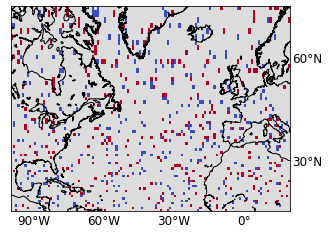

In [201]:
plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(nrows=1, ncols=1)

toshow = np.zeros(rvals.shape)
toshow[rvals < -0.075] = -1
toshow[rvals > 0.075] = 1

plotting.show_pattern(
    toshow[0],
    pmin=-1, pmax=1, pcenter=0,
    axs=axs, colours='coolwarm', units="R-Values")

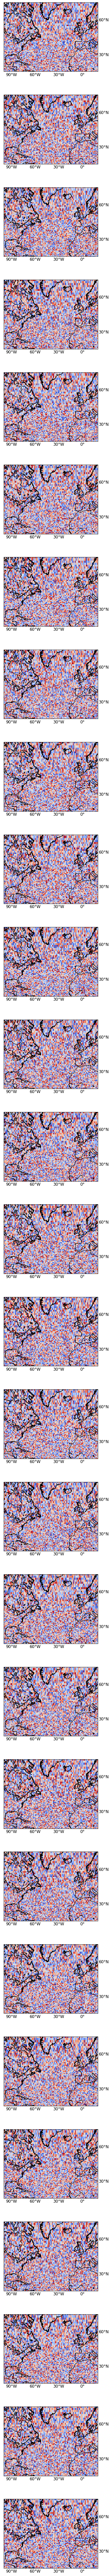

In [186]:
plt.rcParams['figure.figsize'] = [5, 28*5]
fig, axs = plt.subplots(nrows=28, ncols=1)

for n in range(28):    
    plotting.show_pattern(
            pvals[n],
            pmin=0, pmax=1, pcenter=.5,
            axs=axs[n], colours='coolwarm', units="R-Values")

In [ ]:
plt.rcParams['figure.figsize'] = [5*3, 5*2]
fig, axs = plt.subplots(nrows=2, ncols=3)
titles = ["(a)", "(b)", "(c)"]

### MSLP ONLY
for lt_idx, lt in enumerate(variants):
    for r_idx, r in enumerate([7, 8]):
        to_show = np.zeros(variants[lt]['attributions'][r][0, :, :].shape)
        zero_percentile = None
        for pc in np.arange(0, 100, 5):
            perc = np.percentile(variants[lt]['attributions'][r][0, :, :].flatten(), pc)
            to_show[variants[lt]['attributions'][r][0, :, :] >= perc] = pc
            if 0 >= perc:
                zero_percentile = pc
        # Remove the effect of anything in the zero'th percentile
        to_show[to_show == zero_percentile] = 50
        #print(zero_percentile)
        plotting.show_pattern(
            to_show,
            pmin=0, pmax=100, pcenter=50,
            axs=axs[r_idx, lt_idx], colours='coolwarm', units="Normalized Attributions")
        axs[r_idx, 0].set_ylabel(regions[r])
    axs[0, lt_idx].set_title(titles[lt_idx])# + "[{} months]".format(lt))

cb = fig.colorbar(
    ScalarMappable(norm=Normalize(vmin=0, vmax=100), cmap='coolwarm'),
    ax=axs,
    orientation='horizontal',
    aspect=30,
    label="Percentile",
    pad=0.045)
cb.ax.tick_params(labelsize=12)

## Activation Playing

In [19]:
slow_fusion_models[0].summary()

Model: "slow_fusion_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 3, 30, 60, 8)      136       
_________________________________________________________________
sequential_9 (Sequential)    (None, 3, 30, 60, 8)      136       
_________________________________________________________________
sequential_10 (Sequential)   (None, 3, 30, 60, 8)      136       
_________________________________________________________________
sequential_11 (Sequential)   (None, 3, 30, 60, 8)      136       
_________________________________________________________________
sequential_12 (Sequential)   (None, 2, 14, 29, 8)      520       
_________________________________________________________________
sequential_13 (Sequential)   (None, 2, 14, 29, 8)      520       
_________________________________________________________________
sequential_14 (Sequential)   (None, 1, 6, 14, 8)     

In [20]:
videos.shape

(84, 28, 61, 121, 2)

In [21]:
ig  = IntegratedGradients(slow_fusion_models[0],
                          layer=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=20)

AttributeError: Layer slow_fusion_1 is not connected, no input to return.

In [32]:
explanation = ig.explain(np.random.rand(1, 28, 61, 121, 2),
                         baselines=np.zeros((1, 28, 61, 121, 2)),
                         target=None)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [33]:
attributions = explanation.attributions


In [34]:
print(len(attributions))
print(attributions[0].shape)

1
(100, 61, 121, 2)


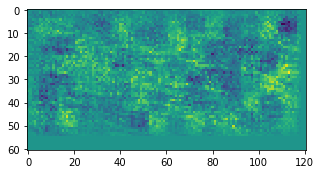

In [39]:
plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(nrows=1, ncols=1)

axs.imshow(np.mean(attributions[0][:, :, :, 0], axis=0))

In [37]:
axs.imshow(np.mean(attributions[0][:, :, :, 1], axis=0))

In [ ]:
[:, 2:]